# Creation of molecular embeddings for classifying compounds using Transformers

## Obtaining Data

Get the latest version of the dataset from the repository

In [1]:
import numpy as np
import pandas as pd
import requests
import io

url = 'https://github.com/GLambard/Molecules_Dataset_Collection/raw/master/originals/HIV.csv'

data = requests.get(url).content
df = pd.read_csv(io.StringIO(data.decode('utf-8')), index_col = 0)
df.reset_index(inplace=True)
df

,smiles,activity,HIV_active
0,CCC1=[O+][Cu-3]2([O+]=C(CC)C1)[O+]=C(CC)CC(CC)...,CI,0
1,C(=Cc1ccccc1)C1=[O+][Cu-3]2([O+]=C(C=Cc3ccccc3...,CI,0
2,CC(=O)N1c2ccccc2Sc2c1ccc1ccccc21,CI,0
3,Nc1ccc(C=Cc2ccc(N)cc2S(=O)(=O)O)c(S(=O)(=O)O)c1,CI,0
4,O=S(=O)(O)CCS(=O)(=O)O,CI,0
...,...,...,...
41122,CCC1CCC2c3c([nH]c4ccc(C)cc34)C3C(=O)N(N(C)C)C(...,CI,0
41123,Cc1ccc2[nH]c3c(c2c1)C1CCC(C(C)(C)C)CC1C1C(=O)N...,CI,0
41124,Cc1ccc(N2C(=O)C3c4[nH]c5ccccc5c4C4CCC(C(C)(C)C...,CI,0
41125,Cc1cccc(N2C(=O)C3c4[nH]c5ccccc5c4C4CCC(C(C)(C)...,CI,0


## Pre-Processing Data

In [2]:
from smiles_processed import smile_array as sp

Process all SMILES in the dataset

In [3]:
processed_smiles, smiles_lengths = sp().process_smiles_array(df['smiles'].values)

Insert processed SMILES and respective lengths into the dataset

In [4]:
df['processed_smiles'] = processed_smiles
df['smiles_length'] = smiles_lengths
df

,smiles,activity,HIV_active,processed_smiles,smiles_length
0,CCC1=[O+][Cu-3]2([O+]=C(CC)C1)[O+]=C(CC)CC(CC)...,CI,0,C C C 1 = [ O + ] [ Cu - 3 ] 2 ( [ O + ] = C (...,51
1,C(=Cc1ccccc1)C1=[O+][Cu-3]2([O+]=C(C=Cc3ccccc3...,CI,0,C ( = C c 1 c c c c c 1 ) C 1 = [ O + ] [ Cu -...,83
2,CC(=O)N1c2ccccc2Sc2c1ccc1ccccc21,CI,0,C C ( = O ) N 1 c 2 c c c c c 2 Sc 2 c 1 c c c...,31
3,Nc1ccc(C=Cc2ccc(N)cc2S(=O)(=O)O)c(S(=O)(=O)O)c1,CI,0,N c 1 c c c ( C = C c 2 c c c ( N ) c c 2 S ( ...,47
4,O=S(=O)(O)CCS(=O)(=O)O,CI,0,O = S ( = O ) ( O ) C C S ( = O ) ( = O ) O,22
...,...,...,...,...,...
41122,CCC1CCC2c3c([nH]c4ccc(C)cc34)C3C(=O)N(N(C)C)C(...,CI,0,C C C 1 C C C 2 c 3 c ( [ n H ] c 4 c c c ( C ...,55
41123,Cc1ccc2[nH]c3c(c2c1)C1CCC(C(C)(C)C)CC1C1C(=O)N...,CI,0,C c 1 c c c 2 [ n H ] c 3 c ( c 2 c 1 ) C 1 C ...,71
41124,Cc1ccc(N2C(=O)C3c4[nH]c5ccccc5c4C4CCC(C(C)(C)C...,CI,0,C c 1 c c c ( N 2 C ( = O ) C 3 c 4 [ n H ] c ...,60
41125,Cc1cccc(N2C(=O)C3c4[nH]c5ccccc5c4C4CCC(C(C)(C)...,CI,0,C c 1 c c c c ( N 2 C ( = O ) C 3 c 4 [ n H ] ...,60


Plot a histogram with the distribution of the lengths of the SMILES in the dataset

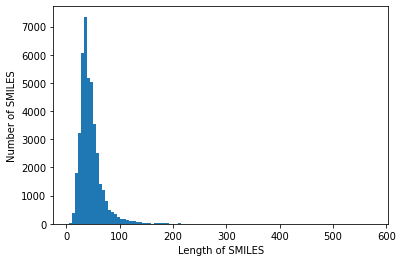

In [5]:
import matplotlib.pyplot as plt

plt.hist(smiles_lengths, bins=100)
plt.ylabel('Number of SMILES')
plt.xlabel('Length of SMILES')
plt.show()

Check the percentage of the instances from the dataset where the length of the SMILES is too small/big

In [6]:
length_range = (15, 125)

filtered = filter(lambda x: length_range[0] <= x <= length_range[1], smiles_lengths)
percentage = len(list(filtered)) / len(processed_smiles)
print('Percentage of instances with SMILES\' length between %s and %s: %s' % (length_range[0], length_range[1], percentage))

sequence_length = length_range[1]

Percentage of instances with SMILES' length between 15 and 125: 0.9813018211880273


In [7]:
sequence_length

125

Remove instances from the dataset where the length of the SMILES is too small/big

In [8]:
df = df[(df['smiles_length'] >= length_range[0]) & (df['smiles_length'] <= length_range[1])]
df = df.drop('smiles_length', axis='columns')
df

,smiles,activity,HIV_active,processed_smiles
0,CCC1=[O+][Cu-3]2([O+]=C(CC)C1)[O+]=C(CC)CC(CC)...,CI,0,C C C 1 = [ O + ] [ Cu - 3 ] 2 ( [ O + ] = C (...
1,C(=Cc1ccccc1)C1=[O+][Cu-3]2([O+]=C(C=Cc3ccccc3...,CI,0,C ( = C c 1 c c c c c 1 ) C 1 = [ O + ] [ Cu -...
2,CC(=O)N1c2ccccc2Sc2c1ccc1ccccc21,CI,0,C C ( = O ) N 1 c 2 c c c c c 2 Sc 2 c 1 c c c...
3,Nc1ccc(C=Cc2ccc(N)cc2S(=O)(=O)O)c(S(=O)(=O)O)c1,CI,0,N c 1 c c c ( C = C c 2 c c c ( N ) c c 2 S ( ...
4,O=S(=O)(O)CCS(=O)(=O)O,CI,0,O = S ( = O ) ( O ) C C S ( = O ) ( = O ) O
...,...,...,...,...
41122,CCC1CCC2c3c([nH]c4ccc(C)cc34)C3C(=O)N(N(C)C)C(...,CI,0,C C C 1 C C C 2 c 3 c ( [ n H ] c 4 c c c ( C ...
41123,Cc1ccc2[nH]c3c(c2c1)C1CCC(C(C)(C)C)CC1C1C(=O)N...,CI,0,C c 1 c c c 2 [ n H ] c 3 c ( c 2 c 1 ) C 1 C ...
41124,Cc1ccc(N2C(=O)C3c4[nH]c5ccccc5c4C4CCC(C(C)(C)C...,CI,0,C c 1 c c c ( N 2 C ( = O ) C 3 c 4 [ n H ] c ...
41125,Cc1cccc(N2C(=O)C3c4[nH]c5ccccc5c4C4CCC(C(C)(C)...,CI,0,C c 1 c c c c ( N 2 C ( = O ) C 3 c 4 [ n H ] ...


In [9]:
df.to_csv("/content/HIV.csv")

In [10]:
from loaders.Loaders import CSVLoader

In [11]:
dataset = CSVLoader(dataset_path='HIV.csv', 
                    mols_field='processed_smiles', 
                    labels_fields='HIV_active')#, shard_size=4000)
dataset = dataset.create_dataset()
dataset.get_shape()

Mols_shape:  40358
Features_shape:  X not defined!
Labels_shape:  (40358,)


# DeepMol Pipeline

Install necessary packages

In [13]:
from IPython.display import clear_output 
!pip install transformers
clear_output()

Using Dataset.py from DeepMol Framework

In [14]:
from Datasets.Datasets import Dataset
from typing import Any, Optional
import numpy as np

from transformers import TFAutoModel, AutoTokenizer
from tqdm import tqdm
import tensorflow as tf

class Transformer(object):

  def __init__(self):
    self.tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')
    self.model = TFAutoModel.from_pretrained('bert-base-cased')

  def tokenize(self, sequence):
    return self.tokenizer.encode_plus(sequence,                    # sequence to tokenize
                                 max_length=125,  # maximum length for the sequence
                                 truncation=True,             # truncate any sequence longer than the maximum length
                                 padding='max_length',        # allow any sequence shorter than the maximum length to be padded
                                 add_special_tokens=True,     # allow special tokens (important for BERT)
                                 return_attention_mask=True,  # output attention_mask needed
                                 return_token_type_ids=False, # output token_type_ids not needed 
                                 return_tensors='tf')         # return TensorFlow tensors
    return tokens


  def get_embedding(self, sequence):
    input_ids = self.tokenize(sequence)              # sequence tokenization
    outputs = self.model(input_ids)                  # run the sequence through BERT
    last_hidden_state = outputs[0]              # get the last hidden state
    vectors = last_hidden_state[0]              # get the token vectors from the last hidden state
    embedding = tf.reduce_mean(vectors, axis=0) # calculate the average for all token vectors
    return embedding.numpy()
  
  def featurize(self, dataset: Dataset, log_every_n=1000):
    molecules = dataset.mols
    embeddings = []
    #for smiles in tqdm(processed_smiles):
    for mol in tqdm(molecules):
      embedding = self.get_embedding(mol)
      embeddings.append(embedding)
    dataset.X = np.asarray(embeddings)
    return dataset

In [15]:
dataset = Transformer().featurize(dataset)
dataset.get_shape()

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.
100%|██████████| 40358/40358 [1:22:33<00:00,  8.15it/s]


Mols_shape:  40358
Features_shape:  (40358, 768)
Labels_shape:  (40358,)


# Testing ML

Random Forest

In [18]:
from splitters.splitters import SingletaskStratifiedSplitter
from models.sklearnModels import SklearnModel
from metrics.Metrics import Metric
from metrics.metricsFunctions import roc_auc_score, precision_score, accuracy_score, confusion_matrix, classification_report, f1_score
from parameterOptimization.HyperparameterOpt import GridHyperparamOpt

from sklearn.ensemble import RandomForestClassifier

In [19]:
#Data Split
splitter = SingletaskStratifiedSplitter()
train_dataset, valid_dataset, test_dataset = splitter.train_valid_test_split(dataset=dataset, frac_train=0.6, 
                                                                             frac_valid=0.2, frac_test=0.2)

In [20]:
#Scikit-Learn Random Forest
rf = RandomForestClassifier()
model = SklearnModel(model=rf)

In [21]:
#cross validation
model.cross_validate(dataset, Metric(roc_auc_score), folds=3)

Computing Stratified K-fold split
Train Score: 
roc_auc_score: 
 1.0
Test Score: 
roc_auc_score: 
 0.5526102597901906
Train Score: 
roc_auc_score: 
 0.9994419642857143
Test Score: 
roc_auc_score: 
 0.5429885311967925
Train Score: 
roc_auc_score: 
 1.0
Test Score: 
roc_auc_score: 
 0.5407563469481919


(SklearnModel(model=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                           class_weight=None, criterion='gini',
                                           max_depth=None, max_features='auto',
                                           max_leaf_nodes=None, max_samples=None,
                                           min_impurity_decrease=0.0,
                                           min_impurity_split=None,
                                           min_samples_leaf=1,
                                           min_samples_split=2,
                                           min_weight_fraction_leaf=0.0,
                                           n_estimators=100, n_jobs=None,
                                           oob_score=False, random_state=None,
                                           verbose=0, warm_start=False),
              model_dir='/tmp/tmprdmxojz2'),
 1.0,
 0.5526102597901906,
 [1.0, 0.9994419642857143, 1.0],
 [0.55261025979

In [22]:
# model training
model.fit(train_dataset)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [23]:
metrics = [Metric(roc_auc_score), Metric(precision_score), Metric(accuracy_score), Metric(confusion_matrix), 
           Metric(classification_report)]
print("#############################")
# evaluate the model
print('Training Dataset: ')
train_score = model.evaluate(train_dataset, metrics)
print("#############################")
print('Validation Dataset: ')
valid_score = model.evaluate(valid_dataset, metrics)
print("#############################")
print('Test Dataset: ')
test_score = model.evaluate(test_dataset, metrics)
print("#############################")

#############################
Training Dataset: 
roc_auc_score: 
 1.0
precision_score: 
 1.0
accuracy_score: 
 1.0
confusion_matrix: 
 [[23408     0]
 [    0   802]]
classification_report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     23408
           1       1.00      1.00      1.00       802

    accuracy                           1.00     24210
   macro avg       1.00      1.00      1.00     24210
weighted avg       1.00      1.00      1.00     24210

#############################
Validation Dataset: 
roc_auc_score: 
 0.5406858785226656
precision_score: 
 0.7333333333333333
accuracy_score: 
 0.9686493184634448
confusion_matrix: 
 [[7795    8]
 [ 245   22]]
classification_report: 
               precision    recall  f1-score   support

           0       0.97      1.00      0.98      7803
           1       0.73      0.08      0.15       267

    accuracy                           0.97      8070
   macro avg       0.85      0